# Create a multi-panel figure showing parametric dependency of some variable changes to global temperature change,  using results of an upstream computation of season and space aggregated changes (e.g. for hydrological variables)
### Input is a json file such as the one produced by (and described in) companion notebook


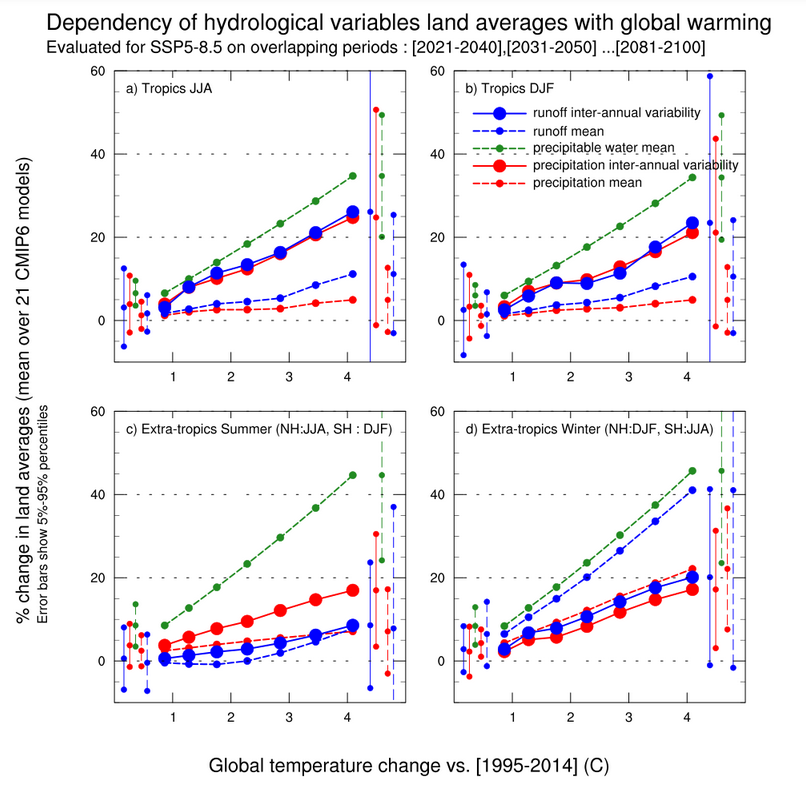

### Caption of fig SOD8.16 as of nov 2019 : 
Relative change (%) in seasonal mean atmospheric moisture (green dotted line), precipitation (red dashed lines), runoff (blue dashed lines), as well as in standard deviation of precipitation (red solid lines) and runoff (blue solid lines) averaged over 
 - extra-tropical land in (a) summer and (b) winter, and 
 - tropical land in (c) JJA and (d) DJF 

as a function of global-mean surface temperature for the CMIP6 multi-model mean across the SSP5-8.5 scenario. 

Each marker indicates a 21-year period centered on consecutive decades between 2015 and 2085 relative to the 1995–2014 base period. 

Precipitation and runoff variability are estimated by their standard deviation after removing linear trends from each time series.

In [ ]:
do_test=True

# scenario to plot
scenario  =  "ssp585"

# pairs of (variable,time statistics) to plot [ assuming that compute phase produced it ! ]
variables = [("pr","mean"),("pr","std"),("prw","mean"),("mrro","mean"),("mrro","std")]

excluded_models= {"mrro": [ "CAMS-CSM1-0" ]}

# Seasons to plot [ assuming that compute phase produced it ! ]
seasons   = ["tropics_JJA","tropics_DJF","extra_summer","extra_winter"]

# Which ensemble statistics should be shown as error bars. Refer to conventions in compute script. 
# Can be None ( for 'no error bars'), but then must change yaxis_title 
ensemble_stat = "nq95" 

# The directory holding input (json) files
indir                = "./changes"

# next tag is a component of input data filename
data_versions_tag    = "20200719d"

# Version is a suffix both for input data and figure filenames. 
version               = ""

figure_name           = "Fig8-16"
outdir                = "./figures"


########################################
# Plot tuning (Ncl/PyNgl conventions)
########################################

layout      = [2,2] # How to organize the set of seasonal plots
title       = "SSP5-8.5 rate of change in land mean and inter-annual variability with global warming"
title       = "Dependency of hydrological variables land averages with global warming"+\
              "~Z70~~C~Evaluated for SSP5-8.5 on overlapping periods : [2021-2040],[2031-2050] ...[2081-2100]"
yaxis_title = "Change in land-averaged mean or inter-annual variability of precipitation, ~C~runoff, moisture (%%)"+\
                        "~Z75~(%d models ensemble mean, 5 and 95 percentiles)"
yaxis_title = "%% change in land averages (mean over %d CMIP6 models)~Z75~~C~Error bars show 5%%-95%% percentiles"
xaxis_title = "Global temperature change for [2021-2040],[2031-2050] ...[2081-2100] vs. [1995-2014] (C)"
xaxis_title = "Global temperature change vs. %s (C)"
#
seasons_description = [ "a) Tropics JJA", 
                        "b) Tropics DJF", 
                        "c) Extra-tropics Summer (NH:JJA, SH : DJF)", 
                        "d) Extra-tropics Winter (NH:DJF, SH:JJA)"
                      ]
#
seasons_showing_legend = ["tropics_DJF"]
show_all_error_bars    = True  # False -> only at both end; True -> for all data points
show_all_error_bars    = False

colors          = {"pr" : "red", "huss" : "black", "prw" : "forestgreen", "mrro" : "blue"}
xyMarkLineModes = {"mean" : "MarkLines", "std" : "MarkLines"}
xyDashPatterns  = {"mean" : 1, "std" : 0 , "wmean" : 8 , "iwmean" : 4}  # mean : 16
xyMarkerSizes   = {("pr","mean") : 0.015,("mrro","mean") : 0.015,("prw","mean") : 0.015, 
                       ("pr","std") : 0.026,("mrro","std"): 0.026,}

# Labels used for variables and time statistics
nice            = {"pr"   : "precipitation",
                   "prw"  : "precipitable water",
                   "mrro" : "runoff",
                   "std"  : "inter-annual variability",
                   "mean" : "mean",
                  }

In [ ]:
if do_test :
    seasons   = ["tropics_JJA" ]
    seasons_description = [ "Tropics JJA" ]
    seasons_showing_legend = ["tropics_JJA"]
    layout = [1,1]

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
import numpy as np
import Ngl
import os
import json
from IPython.display import Image

In [ ]:
def season_plot(wks,stats,season,variables=[("pr","mean"),("pr","std"),("mrro","mean"),("prw","mean")],errors="second"):
    """
    
    """
    #
    # Gathering time series of ensemble mean of relevant time_statistics
    means=[]  
    for variable,stat in variables :
        #print "trying "+variable
        d=stats[variable][stat][season]["mean"]
        periods=sorted(d.keys()) 
        means.append([ d[p] for p in periods ])
    y = np.array(means,np.float32)
    #
    # Gathering x-axis values
    GTAS  = [ stats["tas"]["mean"]["globe_year"]["mean"][p] for p in periods ]
    #
    #
    #-- set plot resources
    res            =  Ngl.Resources()             #-- generate an res object for plot
    res.nglDraw    = False                        # don't draw
    res.nglFrame   = False                        # don't advance frame
    #
    res.trYMinF = -20.0  # -10.
    res.trYMaxF = 70.0   # 60.
    res.trXMinF = 0.5
    res.trXMaxF = 6.0
    #
    res.tmYMajorGrid  = True
    #dpat = Ngl.new_dash_pattern(wks,"________$___________$___________$___________$___")
    dpat = Ngl.new_dash_pattern(wks,"_____$_____$_____$_____$_____$_____$_____$_____$_____$_____")
    res.tmYMajorGridLineDashPattern =  dpat #15
    #
    # Tick marks stuff
    #
    res.tmYLMode         = "Manual"
    res.tmYLTickStartF   = -20.
    res.tmYLTickSpacingF =  20
    #
    res.tmXBMode = "Explicit"
    res.tmXBValues = [ 2,3,4,5 ]
    res.tmXBLabels = [ "2","3","4","5"] 
    #
    res.tiYAxisString    = ""
    res.tiXAxisString    = ""   #-- x-axis title
    #
    #-- xy-plot resources
    #
    res.xyLineColors     = [colors.get(v,"black") for v,s in variables] #-- set 3 different colors for lines
    res.xyLineThicknessF =  4.0     #3.0              #-- line thickness for all
    res.xyDashPatterns   = [ xyDashPatterns [s] for v,s in variables]
    #
    res.xyMarkLineModes  = [ xyMarkLineModes[s] for v,s in variables]
    res.xyMarker         = 16
    res.xyMarkerSizes    = [ xyMarkerSizes.get(v,0.01) for v in variables]
    res.xyMarkerColors   = [colors.get(v,"black") for v,s in variables] 
    
    #-- legend resources
    res.lgAutoManage     = False
    res.xyExplicitLegendLabels = ["  "+nice.get(v,v)+" "+nice.get(s,s) for v,s in variables ]  #-- set explicit legend labels
    res.lgLabelJust      = "CenterLeft"
    if season  in seasons_showing_legend :
        res.pmLegendDisplayMode = "Always"            #-- turn on the drawing
    else :
        res.pmLegendDisplayMode = "Never"             #-- turn off the drawing
    res.pmLegendZone     =  0                         #-- legend zone: 0 = topLeft; 6 = topRight
    res.pmLegendOrthogonalPosF =  0.4                 #-- move the legend upwards
    res.pmLegendParallelPosF =  -0.45                 #-- move the legend upwards
    res.lgJustification  = "TopLeft"                  #-- legend justification
    res.pmLegendWidthF   =  0.2                       #-- change width
    res.pmLegendHeightF  =  0.2
    res.lgLabelFontHeightF = 0.02
    res.pmLegendSide     = "Top"                      #-- Change location
    res.lgPerimOn        =  False                     #-- turn off the perimeter
    res.xyLineLabelFontColors = [colors.get(v,"black") for v,s in variables]

    #-- creates the plot
    plot=Ngl.xy(wks,GTAS,y,res)
    
    
    # Handling error bars
    #####################
    def dic2list(v,s,season,stat): #returns a time-sorted list of values for a given ensemble stat
        dic=stats[v][s][season][stat]
        periods=dic.keys()
        periods.sort()
        l=[ dic[p] for p in periods ]
        return np.array(l,np.float32)
                                            
    def ups_and_lows(v,s,season,stat): #returns two time-sorted list of values for a given ensemble stat
        if stat in ["second","butlast"] :
            ups =dic2list(v,s,season,"butlast")
            lows =dic2list(v,s,season,"second")
        elif errors in ["nq5", "nq95"] :
            ups =dic2list(v,s,season,"nq95")
            lows =dic2list(v,s,season,"nq5")
        elif errors in ["max", "min"] :
            ups =dic2list(v,s,season,"max")
            lows =dic2list(v,s,season,"min")
        elif errors == "means"  and "wmean" in stats[v][season] :
            ups =dic2list(v,s,season,"wmean")
            lows =dic2list(v,s,season,"iwmean")
        else : 
            raise ValueError("errors option '%s' not (yet?) available"%errors)
        #
        return ups,lows

                                            
    if errors is not None :
        for v,s in variables :
            polyres                   =  Ngl.Resources()
            #
            # Tune markers and line color depending on variable and time statistics
            #if s=="std" :
            polyres.gsMarkerIndex     = 1        
            #else :
            #    polyres.gsMarkerIndex     = 2        
            polyres.gsMarkerSizeF     = .03     
            polyres.gsMarkerColor     = colors.get(v,"black")
            polyres.gsLineColor       = colors.get(v,"black")
            polyres.gsLineThicknessF  = 2. #1.5
            polyres.gsLineDashPattern = xyDashPatterns[s]
            #
            # x-wise shift of markers , depending on variable and time statistics
            if    v=="pr"   : delta=0.05
            elif  v=="mrro" : delta=0.1
            else            : delta=0.
            if    s=="std"  : delta=-delta
        #
            ups,lows=ups_and_lows(v,s,season,errors)
            centers=dic2list(v,s,season,"mean")

            bars=zip(GTAS,centers,ups,lows)
            extra_delta=0.5
            if show_all_error_bars is False :
                bars=[bars[0],bars[-1]]
                delta=delta*2
            index=0
            for t,center,up,low in bars :
                if show_all_error_bars is False : 
                    if index==0 : t-=extra_delta
                    if index==1 : t+=extra_delta
                    Ngl.add_polymarker(wks,plot,t+delta,center,polyres)
                Ngl.add_polymarker(wks,plot,t+delta,up,polyres)
                Ngl.add_polymarker(wks,plot,t+delta,low,polyres)
                Ngl.add_polyline  (wks,plot,[t+delta,t+delta],[up,low],polyres)
                index+=1
            
        #
    return plot

In [ ]:
def figure(stats,outname,variables,errors,nb_models,ref_period):
    #
    wks_type        = "png"                       #-- output type of workstation
    wks             =  Ngl.open_wks(wks_type,outname)
    #
    tires                       = Ngl.Resources()  
    tires.txFontHeightF         = 0.02
    tires.txJust                = "TopCenter"
    tiid = Ngl.text_ndc(wks, title, 0.5, 0.98,tires)
    # 
    txres                       = Ngl.Resources()  
    txres.txFontHeightF         = 0.016
    txres.txAngleF              = 90
    txres.txJust                = "TopCenter"
    txid = Ngl.text_ndc(wks, yaxis_title%nb_models, 0.02,0.52,txres)
    #
    tbres                       = Ngl.Resources()  
    tbres.txFontHeightF         = 0.017
    tbres.txJust                = "BottomCenter"
    xtitle                      = xaxis_title%ref_period
    print xtitle,type(xtitle)
    tbid = Ngl.text_ndc(wks, xtitle,
                        0.50, 0.05,tbres)
    #
    plots=[]
    for season in seasons :
        plots.append(season_plot(wks,stats,season,variables,errors))
    #
    panelres =  Ngl.Resources()  
    panelres.nglPanelFigureStrings  = seasons_description
    panelres.nglPanelFigureStringsJust        = "TopLeft"
    panelres.nglPanelFigureStringsPerimOn  = False
    panelres.nglPanelFigureStringsFontHeightF  = 0.012
    panelres.nglPanelLabelBar = True
    #panelres.nglPanelLeft = 0.05
    panelres.nglPanelTop  = 0.92
    #
    panel=Ngl.panel(wks,plots,layout,panelres)                
    #Ngl.frame(wks)         # flush graphics to the wks
    Ngl.delete_wks(wks)    #-- this need to be done to cope with opened wks max number
    return outname+"."+wks_type


In [ ]:
#indir="/data/ssenesi/dev/test_pm/fig_SOD_8.16/changes/"

In [ ]:
project="CMIP6"
with open ("%s/stats_%s_%s%s.json"%(indir,project,data_versions_tag,version),"r") as f :
    stats=json.load(f)

figname ="rate_%s_%s%s"%(scenario,data_versions_tag,version)
if not os.path.exists(outdir):  os.makedirs(outdir)

nb_models=len(stats[scenario][variables[0][0]]["models"])
ref_period=stats["ref_period"].encode('ascii')

fig=figure(stats[scenario],outdir+"/"+figname,variables,ensemble_stat,nb_models,ref_period)
os.system("cd %s ; ln -sf %s.png %s%s.png"%(outdir,figname,figure_name,version))

Image(fig)

In [ ]:
all_metadata=""
for variable,stat in variables + [("tas","mean")]:
    metadata=stats[scenario][variable]["models"]
    for model in metadata :
        all_metadata += metadata[model]
with open("%s/%s%s_md"%(outdir,figure_name,version),"w") as f: f.write(all_metadata)